## Bias in Maching Learning
Made for the Silverpond internship test by Dafu Ai (dafu.ai819@gmail.com / dafua@student.unimelb.edu.au)

Bias in ML refers to when a model is over-fitting the data. (so a good model should aim for a best fit with the data).

This notebook will explain how bias can be found in ML models and how we can address this problem.

To help illustrate my explanations, I use the Iris dataset as the sample data: https://archive.ics.uci.edu/ml/datasets/iris. This is the toy dataset we used when we first learned machine learning in the university. So I think this could be suited for explaining bias, as a basic concept in ML.

Also, to quickly grab a ready-to-use ML classifier, I am using the scikit-learn library http://scikit-learn.org/.

The sample ML model I will use is the support vector machine (SVM). http://scikit-learn.org/stable/modules/svm.html

First, let's load the sample data.

In [37]:
import sklearn 
from sklearn import datasets
from sklearn.model_selection import train_test_split

def load_data():
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # we only take the first two features (i.e. Sepal Width & Sepal Length).
    y = iris.target
    return train_test_split(X, y)

# Split the data into training and testing data
x_train, x_test, y_train, y_test = load_data()

Let's try using a SVM classifier with two different kernels: linear and RBF. (See http://scikit-learn.org/stable/modules/svm.html#svm-kernels)

In [141]:
from sklearn import svm, datasets

# Let's assume we don't know what is C yet.
# ( For RBF, the gamma parameter defines how far the influence of a single training example reaches.
#   See http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html )
linear_model = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)
svm_model = svm.SVC(kernel='rbf', gamma=0.7, C=1).fit(x_train, y_train) 

# Define array can allow us to put into more models
all_models = (linear_model, svm_model)
model_titles = ("Linear Kernel", "RBF Kernel")

# Output the accuracy score of each model over the testing data
def output_model_scores(models, model_titles):
    scores = [model.score(x_test, y_test) for model in all_models]

    for i in range(0, len(scores)):
        print("SVM with", model_titles[i], 'has accuracy', scores[i])

# Do it now
output_model_scores(all_models, model_titles)

SVM with Linear Kernel has accuracy 0.7631578947368421
SVM with RBF Kernel has accuracy 0.7368421052631579


Now let's look into the fitting of the two models in more details:

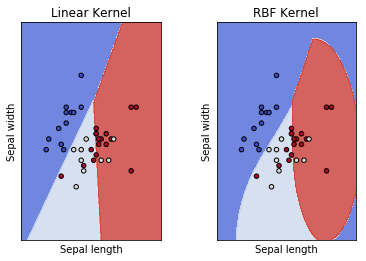

In [140]:
import matplotlib.pyplot as plt

# Acknowledgement: below code is modified based on the example from http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Draw decision boundary plots between each model over the same (testing) data
def draw_comparison_plots(models, model_titles):
    fig, sub = plt.subplots(1, len(models))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = x_test[:, 0], x_test[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, model_titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

# Now we draw fitting graphs for the two models respectively (over the testing data)
draw_comparison_plots(all_models, model_titles)

From the graph above, we can see that the decision boundaries (i.e. boundaries of each coloured shapes ) of RBF-kernel SVM **tend to overfitts more** than the linear kernel. 

As this point, we should also note that the complexity of RBF kernel is greater than the linear kernel.

As above, we can obverse that **increase in model complexity will drive us closer to overfitting** (when we have a fixed training dataset).

So, if we want to decrease our model complexity, we can attempt to limit the effective degrees of freedom of our model, and one such technique is **regularisation**.

### Regularisation
To guard against overfitting, we can apply regularisation. This is a very common approach.

The 'unknown' C value as used in above code snippets, is indeed a regularisation parameter for SVM.

### L1 & L2 Regularisation

With regularisation, there are also two common levels: L1 & L2.

How are L1 & L2 different? In short,
- L1 regularisation encourages solutions where many parameters are zero.
- L2 regularisation encourages solutions where most parameter values are small.

With the SVMs we just used, L2 is being used as default (as it is a standard for SVM).

So, to improve overfitting, we can experimentally adjust the value of the C parameter (or even change the regularisation level until we find the one giving the most accurate models.

Here's an simple example, we try a good range of C and find the model with the highest accuracy (over the training data).

A bestfit model has C = 3.7 with score 0.8303571428571429
An overfit model has C = 0.4 with score 0.7946428571428571


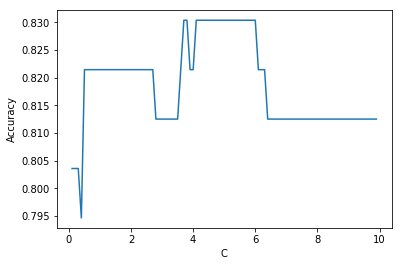

In [161]:
import numpy as np

def get_models_with_c_range(c_range):
    return [svm.SVC(kernel='linear', C=c).fit(x_train, y_train) for c in c_range]

c_range = np.arange(0.1, 10, 0.1)
all_models = get_models_with_c_range(c_range)
scores = [model.score(x_train, y_train) for model in all_models]

best_model = all_models[scores.index(max(scores))]
best_model_score = max(scores)
overfit_model = all_models[scores.index(min(scores))]
overfit_model_score = min(scores)

# Let's see the result!
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(c_range, scores)

print("A bestfit model has C =", best_model.get_params()['C'], 'with score', best_model_score)
print("An overfit model has C =", overfit_model.get_params()['C'], 'with score', overfit_model_score)

### Side: Optimisation
From the persepective of regularisation, **we can conceive learning as optimisation** (on some of the model parameters. 

We can use more advanced techniques to compute the optimal parameters, such as Gradient Descent Algorithm (see http://scikit-learn.org/stable/modules/sgd.html)

### Wrap up
Overall, this notebook only gives very basic explanations on bias and it introduces a few common approaches to address bias. So, the knowledge on bias should of-course not be limted on this notebook, and we should study this topic in greater depth. I believe the knowledge in this area, should be valued by every good ML practitioner.